# Merge HyP3 ISCE2 burst InSAR products

This notebook demonstrates the `merge_tops_burst` workflow in the hyp3-isce2 plugin. The workflow merges multiple Burst InSAR Products. The input of the workflow is the directory that includes multiple HyP3-ISCE2 Burst InSAR Products.These products are created by HyP3-ISCE2 plugin. How to create HyP3 Burst InSAR Product is described in detail in the notebook [hyp3_isce2_burst_stack_for_ts_analysis](https://github.com/ASFHyP3/hyp3-docs/blob/main/docs/tutorials/hyp3_isce2_burst_stack_for_ts_analysis.ipynb).



**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, we suggest checking out the following resources. Note that some of these resources may be specific to our InSAR GAMMA products, so you may need to adapt them for use with our ISCE2-based burst InSAR products.

* Our [Burst Data Download Story Map](https://storymaps.arcgis.com/stories/88c8fe67933340779eddef212d76b8b8)

* Our [product guide](https://hyp3-docs.asf.alaska.edu/guides/burst_insar_product_guide/) for burst InSAR products

* Our [GitHub repository](https://github.com/asfhyp3/hyp3-isce2) containg the workflow used to create burst InSAR products

* Our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)

* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup
To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
git clone https://github.com/ASFHyP3/hyp3-isce2.git
cd hyp3-isce2
mamba env create -f environment.yml
mamba activate hyp3-isce2
python -m pip install -e .
mamba install -c conda-forge pandas jupyter ipympl
jupyter notebook hyp3_isce2_burst_stack_for_ts_analysis.ipynb
```
Edit the .netrc file in your home directory. Just add your earthdata login username and password here. For example,
machine urs.earthdata.nasa.gov
login your_user_name
password your_password

In [1]:
import os
from pathlib import Path
import subprocess
import glob
from dateutil.parser import parse as parse_date
import rasterio
from rasterio.plot import show

### Set parameters

In [2]:
project_name = 'merge_burst_product'
cur_dir = Path.cwd()
work_dir = cur_dir / project_name
data_dir = work_dir / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
PATH_TO_UNZIPPED_PRODUCTS = data_dir
os.chdir(work_dir)

## 1. prepare the input data: burst InSAR products
Assume the burst InSAR Products are in hands. You need copy them to the ${project_name}/data.

In [3]:
src_data_dir = '/home/jiangzhu/data/merge_burst_test/merge_t5'
dst_data_dir = str(PATH_TO_UNZIPPED_PRODUCTS)

cmd = ['cp', '-r'] + glob.glob(f'{src_data_dir}/*') + [f'{dst_data_dir}/']
subprocess.run(cmd)

CompletedProcess(args=['cp', '-r', '/home/jiangzhu/data/merge_burst_test/merge_t5/S1_136232_IW2_20200604_20200616_VV_INT80_491D', '/home/jiangzhu/data/merge_burst_test/merge_t5/S1_136231_IW2_20200604_20200616_VV_INT80_6E56', '/home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/data/'], returncode=0)

## 2. Merge the products using hyp3-isce2 merge_tops_burst workflow.  


In [4]:
cmd = ['python', '-m', 'hyp3_isce2', '++process', 'merge_tops_bursts', f'{str(PATH_TO_UNZIPPED_PRODUCTS)}', '--apply-water-mask', 'True']

In [5]:
subprocess.run(cmd)

/home/jiangzhu/projects/work/hyp3/hyp3-isce2/src/hyp3_isce2/__main__.py:40: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  eps = entry_points()['hyp3']


2024-02-07 16:56:18,971 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-02-07 16:56:23,124 - hyp3_isce2.burst - INFO - Download attempt #1 for https://sentinel1-burst.asf.alaska.edu/S1A_IW_SLC__1SDV_20200604T022251_20200604T022318_032861_03CE65_7C85/IW1/VV/0.xml
API open (R): /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/fine_interferogram/IW2/burst_01.int
API close:  /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/fine_interferogram/IW2/burst_01.int
API open (R): /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/geom_reference/IW2/los_01.rdr
API close:  /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/geom_reference/IW2/los_01.rdr
API open (R): /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/geom_reference/IW2/lat_01.rdr
API close:  /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs

Reading tile metadata:   0%|          | 0/2 [00:00<?, ?it/s]/home/jiangzhu/apps/mambaforge/envs/hyp3-isce2/lib/python3.11/site-packages/dem_stitcher/rio_window.py:99: RuntimeWarning: Requesting extent beyond raster bounds of [53.99986111111111, 27.000138888888888, 54.99986111111111, 28.000138888888888]. Shrinking bounds in raster crs to (53.99986111111111, 27.000138888888888, 54.99986111111111, 28.0).
  warn(
Reading tile imagery: 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


fixing xml file path for file: /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/full_res.dem.wgs84
Writing geotrans to VRT for /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/full_res.dem.wgs84
GDAL open (R): merged/topophase.flat.vrt
API open (WR): merged/filt_topophase.flat
2024-02-07 16:56:52,012 - isce.mroipac.filter - DEBUG - width: 1272
2024-02-07 16:56:52,013 - isce.mroipac.filter - DEBUG - length: 714
2024-02-07 16:56:52,013 - isce.mroipac.filter - DEBUG - input: merged/topophase.flat
2024-02-07 16:56:52,013 - isce.mroipac.filter - DEBUG - output: merged/filt_topophase.flat
2024-02-07 16:56:52,013 - isce.mroipac.filter - DEBUG - filter strength: 0.6
2024-02-07 16:56:52,013 - isce.mroipac.filter - INFO - Filtering interferogram


line:   713

array width, height, offset:  1272   714     0

number of lines written to file: 720
Rescaling magnitude
GDAL close: merged/topophase.flat.vrt
API close:  merged/filt_topophase.flat
GDAL open (R): merged/filt_topophase.flat.vrt
API open (WR): merged/phsig.cor

 << PS filtering >>


 interferogram width:  1272  number of lines/patch:  3700
 start line:        1  number of lines:     714
 start sample:      1  end sample:         1272
 wisdomFile, length =            0

 azimuth buffer size:                             3700
 overlap between azimuth patches:                  200
 total overlap between azimuth patches:            264
 offset in overlap region for phase  bootstrap:    132
 lines to increment for the next patch:           3436
 number of patches:                                  1

 PATCH:   1   starting line:     0    lines read:  714
 starting output line:    1   ending output line:  714

*** Normal Completion  ***

GDAL close: merged/filt_topophase.flat.vrt
API close:  me

Reading wrapped phase from file merged/filt_topophase.flat
No weight file specified.  Assuming uniform weights
Reading correlation data from file merged/masked.phsig.cor
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 2
Flow increment: 1  (Total improvements: 0)
Growing connected component mask
Writing connected components to file merged/filt_topophase.unw.conncomp
Maximum flow on network: 1
Total solution cost: 817744
Integrating phase
Writing output to file merged/filt_topophase.unw
API open (R): merged/filt_topophase.unw
API close:  merged/filt_topophase.unw
GDAL open (R): merged/filt_topophase.unw.vrt
GDAL close: merged/filt_topophase.unw.vrt
API open (R): merged/filt_topophase.unw.conncomp
API close:  merged/filt_topophase.unw.conncomp
GDAL open (R): merged/filt_topophase.unw.conncomp.vrt
GDAL close: merged/filt_topophase.unw.conncomp.vrt
GDAL open (R): merged/filt_topophase.unw.vr

CompletedProcess(args=['python', '-m', 'hyp3_isce2', '++process', 'merge_tops_bursts', '/home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/merge_burst_product/data', '--apply-water-mask', 'True'], returncode=0)

## 3. Dispplay the merged product

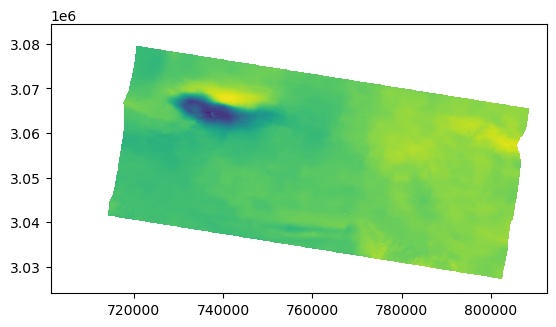

<Axes: >

In [6]:

file = glob.glob('./*/*_unw_phase.tif', recursive = True)[0]

src = rasterio.open(file)

show(src)


In [7]:
os.chdir(cur_dir)
print('completed ...')

completed ...
